In [1]:
import numpy as np
import FewShotCVRP.nn.fnn as fnn
import FewShotCVRP.examples.params_search.simulation as simulation
import FewShotCVRP.ea as ea
import FewShotCVRP.bo.bo_torch as bo_torch

snap = bo_torch.BayesianOptimizer.load_snapshot(
    "../outputs/2025-09-18-17h48m53s/per-instance-param-control/X-n209-k16/bo-final"
)

constants = simulation.SimulationConstants(
    cvrp_instance_str="X-n209-k16.xml",
    ea_window_size=5,
    ea_generations_number=50,
    ea_lambda_=2 * 10**4,
    ea_mutation_operator=ea.mutate_shift_2opt_fast_fast,
    in_dim=10,
    hidden_dims=[15],
    theta_min=1.0,
    theta_max=100.0,
    activation=fnn.nn.SiLU,
)

objective = fnn.NNObjective(
    theta_min=constants.theta_min,
    theta_max=constants.theta_max,
    in_dim=constants.in_dim,
    hidden_dims=constants.hidden_dims,
)

fnn.set_flat_params_(objective.net, np.asarray(snap.result["x_rec_mean_in_data"]))
theta_control_fun = objective.build_function()

In [ ]:
import numpy as np
import FewShotCVRP.utils.fixed_queue as fq


def nn_input_fitness(prv_fitness, cur_fitness):
    C = 10
    return np.exp(C * (np.log(cur_fitness) - np.log(prv_fitness) + 1)) / np.exp(C)


def nn_input_theta(theta):
    return (theta - 1) / 100


window = 5
progress = fq.NumpyFixedQueue(maxlen=2 * window)


def make_up_progress(obj_values, thetas):
    for i in range(len(thetas)):
        prv_fitness = obj_values[i]
        cur_fitness = obj_values[i + 1]
        theta = thetas[i]
        progress.append(nn_input_fitness(prv_fitness, cur_fitness))
        progress.append(nn_input_theta(theta))
    return progress.to_numpy()    

obj_values = [3400, 3300, 3200, 3100, 3000, 2900]
thetas = [10, 9, 8, 7, 6]
nn_input = make_up_progress(obj_values, thetas)

theta = theta_control_fun(nn_input)
print(theta)


### Compare on one run

In [2]:
from importlib import reload

import FewShotCVRP.ea as ea
import FewShotCVRP.examples.params_search.simulation as simulation

reload(ea)

random_seed = 2026

cvrp = simulation.get_cvrp_instance("X-n209-k16.xml")

print("Running theta control")

res_theta_control = ea.one_plus_lambda_ea_with_theta_control(
    cvrp,
    theta_schedule_window=[100.0, 100.0, 50.0, 50.0, 20.0],
    window=constants.ea_window_size,
    theta_control_fun=theta_control_fun,
    seed=random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running descent")


res_descent = ea.descent(
    cvrp=cvrp,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=constants.ea_mutation_operator,
    seed=random_seed,
)
print(res_descent["best_fitness"])

print("Running theta fixed 1")

res_theta_schedule = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=np.linspace(100.0, 1.0, constants.ea_generations_number),
    seed=random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 2")

res_theta_schedule_2 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=[1.0] * constants.ea_generations_number,
    seed=random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

print("Running theta fixed 3")

res_theta_schedule_3 = ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=[10.0] * constants.ea_generations_number,
    seed=random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

Running theta control
[init] fitness=119600.000000
[gen 1] theta=100 fitness=106313.000000 ↑ evals=20001/1000001
[gen 2] theta=100 fitness=104281.000000 ↑ evals=40001/1000001
[gen 3] theta=50 fitness=99497.000000 ↑ evals=60001/1000001
[gen 4] theta=50 fitness=96685.000000 ↑ evals=80001/1000001
[gen 5] theta=20 fitness=93457.000000 ↑ evals=100001/1000001
[gen 6] theta=1.05 fitness=91141.000000 ↑ evals=120001/1000001
[gen 7] theta=1.04 fitness=88105.000000 ↑ evals=140001/1000001
[gen 8] theta=1.18 fitness=86349.000000 ↑ evals=160001/1000001
[gen 9] theta=1.21 fitness=84718.000000 ↑ evals=180001/1000001
[gen 10] theta=1.32 fitness=83336.000000 ↑ evals=200001/1000001
[gen 11] theta=1.21 fitness=81715.000000 ↑ evals=220001/1000001
[gen 12] theta=1.26 fitness=80561.000000 ↑ evals=240001/1000001
[gen 13] theta=1.2 fitness=79021.000000 ↑ evals=260001/1000001
[gen 14] theta=1.17 fitness=77703.000000 ↑ evals=280001/1000001
[gen 15] theta=1.16 fitness=76519.000000 ↑ evals=300001/1000001
[gen 16] 

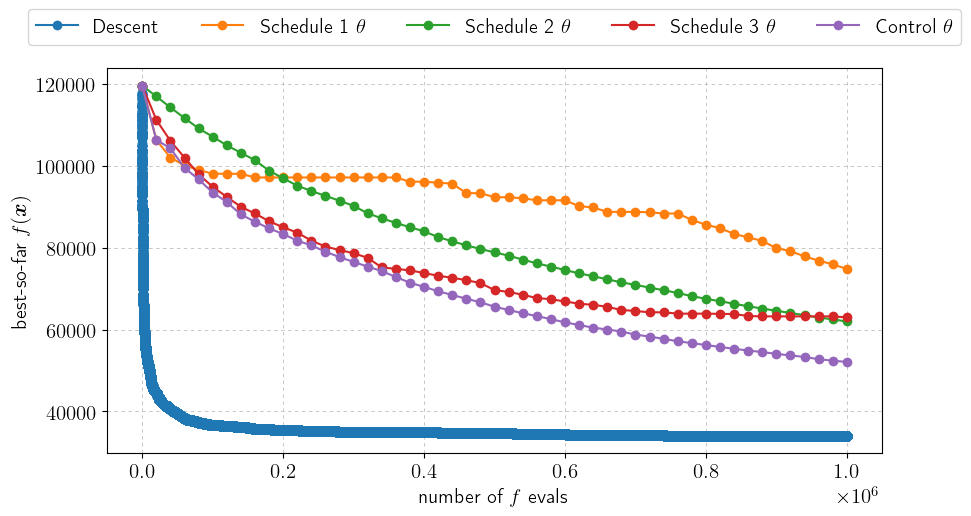

In [3]:
import matplotlib.pyplot as plt

import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()


def plot_trajectories(results_list):
    fig, ax = plt.subplots(figsize=(10, 5))

    for res, label in results_list:
        # Split into x and y lists
        x, theta, y = zip(* res["history"])
        # Plot the data
        ax.plot(x, y, marker="o", label=label)

    # Place legend above the plot (centered)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),  # adjust vertical spacing
        ncol=len(results_list),  # number of columns in legend
        frameon=True,
    )

    ax.set_xlabel("number of $f$ evals")
    ax.set_ylabel(r"best-so-far $f(\bm{x})$")
    # ax.set_title("Plot of (x, y) pairs")

    # plt.tight_layout()
    plt.show()


results_list = [
    (res_descent, "Descent"),
    (res_theta_schedule, r"Schedule 1 $\theta$"),
    (res_theta_schedule_2, r"Schedule 2 $\theta$"),
    (res_theta_schedule_3, r"Schedule 3 $\theta$"),
    (res_theta_control, r"Control $\theta$"),
]
plot_trajectories(results_list)